In [1]:
!pip install transformers torch datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall:

In [2]:
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.decomposition import PCA
from transformers import BertModel, BertTokenizer

2025-08-24 21:13:42.795351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756070022.951551      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756070022.999661      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
dataset = load_dataset("Trelis/protein_stability_single_mutation")
df = pd.DataFrame(dataset["test"])

README.md: 0.00B [00:00, ?B/s]

train.csv:   0%|          | 0.00/230M [00:00<?, ?B/s]

validation.csv:   0%|          | 0.00/29.1M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/28.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/243421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/30748 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/30243 [00:00<?, ? examples/s]

In [5]:
mutation_dict = {}
for WT, group in df.groupby("WT_name"):
    mutation_dict[WT] = {"WTseq":group["base_aa_seq"].iloc[0], "MTseq":group["aa_seq_full"].tolist()}

In [6]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert", torch_dtype="auto")
model.to(device)
model.eval()

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, i

In [7]:
def ExtractAttention(WTsequences, MTsequences, device, batch = 4):
    WTattn = []
    WTsequence = [' '.join(list(seq)) for seq in WTsequences]
    WTseq_spaced = [' '.join(list(seq)) for seq in WTsequences]
    tokens = tokenizer(WTseq_spaced, return_tensors='pt', padding=True, truncation=True)
    tokens = {k: v.to(device) for k, v in tokens.items()}

    with torch.no_grad():
        outputs = model(**tokens, output_attentions=True)
    attn = torch.stack(outputs.attentions).mean(dim=(0,2))  # [batch, L, L]
    WTattn = [t.cpu() for t in attn]  # move to CPU
    del tokens, outputs
    torch.cuda.empty_cache()

    MTattn = []
    
    for i in range(0, len(MTsequences), batch):
        MTseq = MTsequences[i:i+batch]
        MTsequence = [' '.join(list(seq)) for seq in MTseq]
        tokens = tokenizer(MTsequence, return_tensors='pt', padding=True, truncation=True)
        tokens = {k: v.to(device) for k, v in tokens.items()}

        with torch.no_grad():
            outputs = model(**tokens, output_attentions=True)
        attn = torch.stack(outputs.attentions).mean(dim=(0,2))
        MTattn.extend([t.cpu() for t in attn])
        del tokens, outputs
        torch.cuda.empty_cache()  

    return WTattn, MTattn

In [8]:
def PadAttention(attention):
    max_len = max([t.shape[0] for t in attention])

    padded_attention = []
    for t in attention:
        L = t.shape[0]
        if L == max_len:
            padded_attention.append(t.numpy())
        else:
            pad = np.zeros((max_len, max_len), dtype=np.float32)
            pad[:L, :L] = t.numpy()
            padded_attention.append(pad)

    return np.stack(padded_attention)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


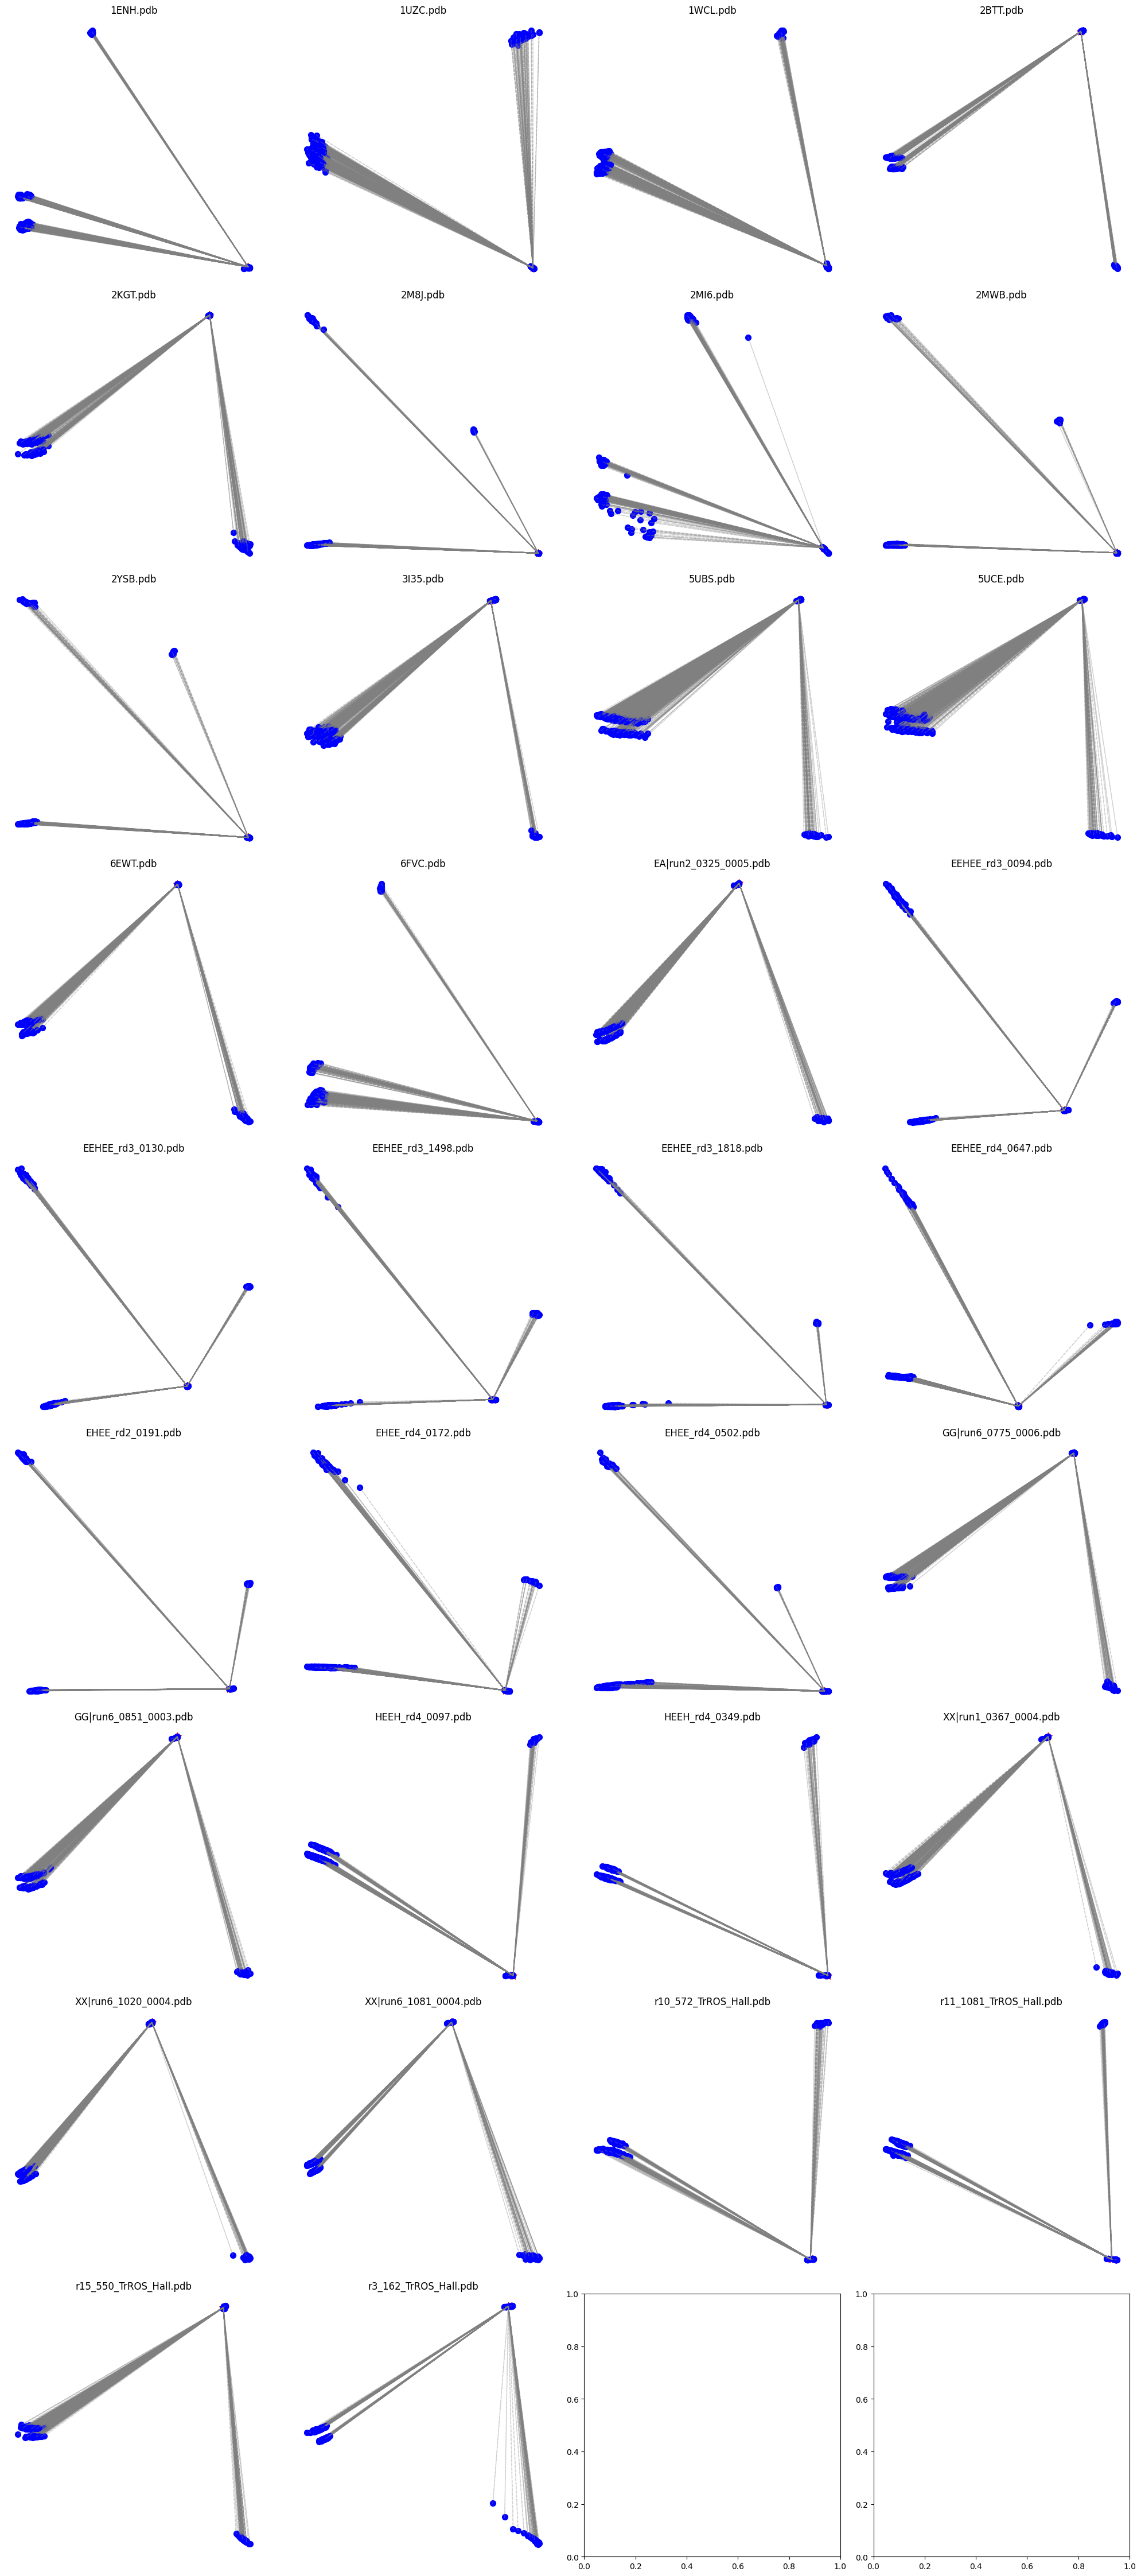

In [9]:
cols = 4
num_wt = len(mutation_dict)
rows = math.ceil(num_wt / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
axes = axes.flatten()

for i, (wt_name, values) in enumerate(mutation_dict.items()):
    WTseq_list = values["WTseq"]   # list of WT sequences
    MTseq_list = values["MTseq"]   # list of mutation sequences

    # Extract attention masks
    WTattn, MTattn = ExtractAttention(WTseq_list, MTseq_list, device, batch = 4)

    all_attn = WTattn + MTattn
    all_attn_padded = PadAttention(all_attn)

    # --- Flatten for PCA ---
    all_attn_flat = [t.flatten() for t in all_attn_padded]
    all_attn_flat = np.stack(all_attn_flat)

    # PCA to 2D
    X_pca = PCA(n_components=2).fit_transform(all_attn_flat)

    # Plot attention shifts in this subplot
    ax = axes[i]
    names = ["original"] + [f"mut_{j}" for j in range(len(MTseq_list))]
    orig_idx = 0
    for j, name in enumerate(names):
        if j == orig_idx:
            ax.scatter(X_pca[j,0], X_pca[j,1], marker="*", s=100, color="red")
        else:
            ax.scatter(X_pca[j,0], X_pca[j,1], marker="o", s=50, color="blue")
            ax.arrow(X_pca[orig_idx,0], X_pca[orig_idx,1],
                     X_pca[j,0]-X_pca[orig_idx,0],
                     X_pca[j,1]-X_pca[orig_idx,1],
                     alpha=0.3, color="gray", linestyle="--")
    ax.set_title(wt_name)
    ax.axis('off')

plt.tight_layout()
plt.show()